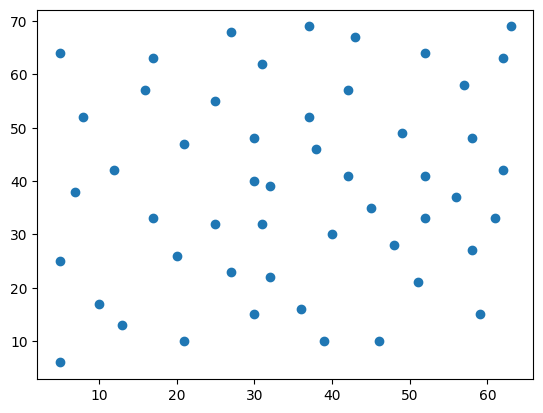

In [292]:
# Reading file

import numpy as np
import matplotlib.pyplot as plt

class City:
    id: int
    x: float
    y: float

    def __init__(self, id, x, y):
        self.x = float(x)
        self.y = float(y)
        self.id = int(id)

file_name = "eil51.tsp.txt"
intro_lines = 6         # MAKE THEM CONSTANT
cities_amount = 51     # MAKE THEM CONSTANT

cities = []
with open(file_name,"r") as f:
    for i in range(intro_lines):
        f.readline()
    for i in range(cities_amount):
        line = f.readline()
        id, x, y = line.split()
        cities.append(City(id, x, y))

coordinates_x = []
coordinates_y = []
for City in cities:
    coordinates_x.append(City.x)
    coordinates_y.append(City.y)
plt.scatter(coordinates_x, coordinates_y)

True
1674.8263713611536


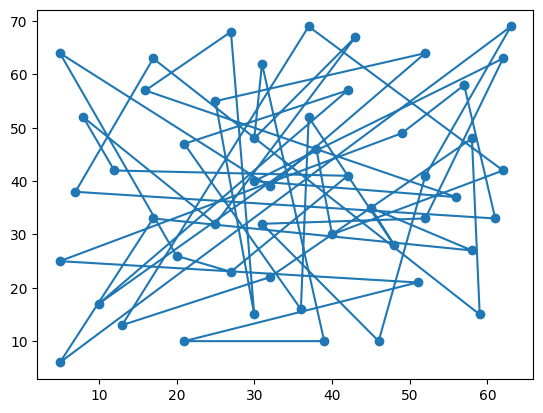

True
764.4875258411532


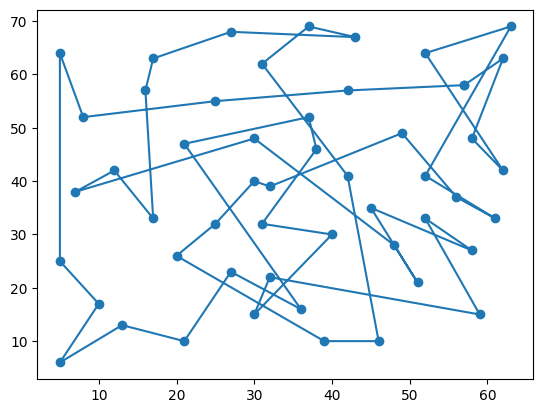

9.8
10000
True
809.358898392275


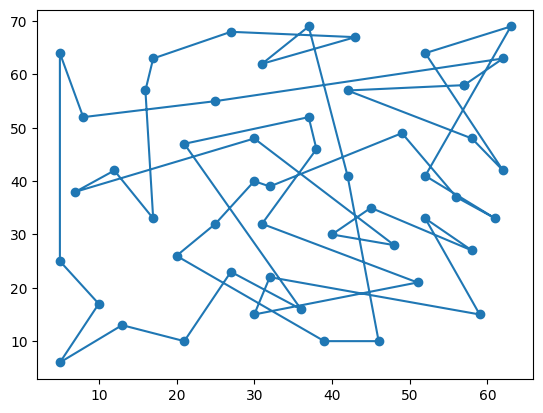

In [334]:
import copy

class Path:
    city_ids = []

    def __init__(self, city_ids = []):
        self.city_ids = copy.deepcopy(city_ids)



# Evaluate Path (Fitness function)
    # Euclidean distance
    def eval_distance(self):
        distance = 0

        for i in range(len(self.city_ids)-1):            
            # Because cities ids are starting from 1, and array starts at 0
            distance += np.sqrt(
            (cities[self.city_ids[i+1]-1].x - cities[self.city_ids[i]-1].x)**2 + 
            (cities[self.city_ids[i+1]-1].y - cities[self.city_ids[i]-1].y)**2 )

        return distance

# Path is invalid if returned to non starting location at the end
    def eval_validity(self):
        if self.city_ids[0] == self.city_ids[-1]:
            return True
        else: return False

# Visualize Path
    def visualize(self):
        coordinates_x = []
        coordinates_y = []
        for i in self.city_ids:
            coordinates_x.append(cities[i-1].x)       # Because cities ids are starting from 1, and array starts at 0
            coordinates_y.append(cities[i-1].y)
        plt.scatter(coordinates_x, coordinates_y)
        plt.plot(coordinates_x, coordinates_y)
        plt.show()



# Optimize Path
    # Rand Permutations +
    # 2-opt
    # 3-opt
    # Other...

    # Rand Permutations, k is amount of swaps
    def generate_new_path_random_swapping(self, k):
        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        city_ids_new = copy.deepcopy(self.city_ids)
        for j in range(0, k, 2):
            city_ids_new[ids_to_swap[j]], city_ids_new[ids_to_swap[j+1]] = city_ids_new[ids_to_swap[j+1]], city_ids_new[ids_to_swap[j]]
        return Path(city_ids_new)
                


# Simplest way to create initial guess is just to shuffle
import random
random.seed(42)
shuffled = sorted(cities, key=lambda k: random.random())
shuffled.append(shuffled[0])    # So that path is cycle
city_ids_init_path = []
for city in shuffled:
    city_ids_init_path.append(city.id)


initial_path = Path(city_ids_init_path)
print(initial_path.eval_validity())     # If everything is ok it should be True
print(initial_path.eval_distance())     # Evaluate circuit size
initial_path.visualize()                # And see it




# Random Permutations to find the better path
path = initial_path
for i in range(10000):
    new_path = path.generate_new_path_random_swapping(k=5)
    if new_path.eval_distance() < path.eval_distance():
        path = new_path

print(path.eval_validity())     # If everything is ok it should be True
print(path.eval_distance())     # Evaluate circuit size
path.visualize()                # And see it


# Annealing
temp = 10
temp_current = temp
t_min = 0

step = 0
step_max = 10000

# begin optimizing
current_path = initial_path
current_energy = initial_path.eval_distance()
while step < step_max and temp >= t_min:
    # Get candidate solution
    candidate_path = path.generate_new_path_random_swapping(k=5)
    candidate_energy = candidate_path.eval_distance()

    delta_energy = candidate_energy - current_energy

    # determine if we should accept the current neighbor
    if np.random.random() < np.exp(-delta_energy / temp):
        current_energy = candidate_energy
        current_path = candidate_path
        #self.accept += 1
    # check if the current neighbor is best solution so far
    #if E_n < self.best_energy:
    #    self.best_energy = E_n
    #    self.best_state = proposed_neighbor[:]

    ## persist some info for later
    #self.hist.append([
    #    self.step,
    #    self.t,
    #    self.current_energy,
    #    self.best_energy])
    ## update some stuff
    temp = temp_current - 0.2  # Here should be cooling schedule
    step += 1

# generate some final stats
#self.acceptance_rate = self.accept / self.step
print(current_path.eval_distance())     # Evaluate circuit size
current_path.visualize()                # And see it

# Future Discussions and further optimizations

 PreCalculate Distance between all cities and use lookup table